<a href="https://colab.research.google.com/github/raghav96/AI_Algorithms/blob/master/project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ELEC5307-2021-S2: Project 1 report

### Name (SID): Raghav Ravisankar (510590684)

Please follow the instructions carefully:
- This project is based on Cifar-10 dataset. The basic loading operations are added already. Please do not use other dataset.
- Remove the corresponding `e.g.` and fill in all the blanks in this file, including some codes in Part 1, your choices for Part 2, your task for Part 3, and the analyses for your choices, specification of your computer, etc.
- Please do not change the format of this report.
- In your analyses, you can add math functions and graphs.
- Please make clear comments and references for any codes written by yourself or copied from other sources.

### Part 0: Prepare for Colab

The default colab uses CPU, you can add GPU resources in Runtime->Change runtime type->dropdown, select GPU->save

**Note: the following code is written for cpu, you need to allocate data and network to GPU on your own if you want to utilize GPU devices.**

### Part 1: Baseline model
You need to run this model successfully to get the marks. You should finish the codes that are used to split the training dataset into training set (45000 images) and validation set (5000 images) and draw the loss curve for training loss and validation loss. 

### 1.1 prepare data

In [ ]:
# useful packages
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn

In [ ]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='/tmp/CIFAR10', train=True,
                                        download=True, transform=transform)
trainset = [item for item in trainset]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/tmp/CIFAR10', train=False,
                                       download=True, transform=transform)
testset = [item for item in testset]
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


### 1.2 split the training data into training and validation
In most of the cases, you are given the test set, so you need to prepare some validation data to evaluate your model during training stage. You need to make a validation dataset that contains 5000 training images, and the rest 45000 images are used as the new training set.

In [ ]:
from torch.utils.data import random_split

# Your split codes here.
# You need to random select the 5000 validation images 
new_trainset, validationset = random_split(trainset, [45000, 5000])
print("Length of training set = ", len(new_trainset))
print("Length of validation set = ", len(validationset))

new_train_loader = torch.utils.data.DataLoader(new_trainset, batch_size=4, shuffle=True, num_workers=2, pin_memory = True)
validation_loader = torch.utils.data.DataLoader(validationset, batch_size=4, shuffle=False, num_workers=2, pin_memory = True)
print("Number of batches for training set = ", len(new_trainset)/4)
print("Number of batches for validation set = ", len(validationset)/4)

# besides, you can also make modifications for faster training 
# by selecting a subset of the original dataset.

small_trainset, large_trainset = random_split(new_trainset, [25000, 20000])
small_train_loader = torch.utils.data.DataLoader(small_trainset, batch_size=4, shuffle=True, num_workers=2, pin_memory = True)
print("Length of small training set for faster training =", len(small_trainset))
# Batch size is 4, so number of batches is total size of training set divided by batch size
print("Number of batches in small training set = ", len(small_trainset)/4)

Length of training set =  45000
Length of validation set =  5000
Number of batches for training set =  11250.0
Number of batches for validation set =  1250.0
Length of small training set for faster training = 25000
Number of batches in small training set =  6250.0


### 1.3 Define a Baseline Convolution Neural Network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(self.relu1(self.conv1(x)))
        x = self.pool(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.cuda()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### 1.4 Define a Loss function and optimizer

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


### 1.5 Train the network

In [ ]:
# This function does the training on the training set, we are using
# the small training set
def train(num_epoch, trainset_loader, validationset_loader, net, criterion, 
          optimizer, train_loss, validation_loss
          #train_acc, 
          #validation_acc
          ):
  print('Training Started')
  for epoch in range(num_epoch):  # loop over the dataset multiple times

      running_loss = 0.0
      # num_pred = 0
      # num_correct_pred = 0
      for i, data in enumerate(trainset_loader, 0):
          # get the inputs and set it to the GPU for faster calculation
          labels = data[1].cuda()
          inputs = data[0].cuda()
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)

          # Making calculations for predictions 
          # and number of correct predictions
          predictions = outputs.argmax(dim = 1)
          
          # creates a list with 1 if prediction is right, 
          # 0 if prediction is wrong
          correct_pred = (predictions == labels)
          num_pred += predictions.size(0)
          num_correct_pred += correct_pred.sum()

          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 11250 == 11249:    # print every 6250 mini-batches

              # Calculating average loss and accuracy and adding it to list
              # to show in graph
              avg_loss = running_loss / 11250
              train_loss.append(avg_loss)

              acc = (num_correct_pred/num_pred) * 100
              train_acc.append(acc.cpu())
              
              print('[%d, %5d] training set loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 11250))
              running_loss = 0.0

      validation_running_loss = 0.0
      validation_num_pred = 0
      validation_num_correct_pred = 0
      best_acc = 0

      for i, data in enumerate(validationset_loader, 0):
          # get the inputs and set it to the GPU for faster calculation
          labels = data[1].cuda()
          inputs = data[0].cuda()
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)

          # Making calculations for predictions 
          # and number of correct predictions
          predictions = outputs.argmax(dim = 1)
          
          # creates a list with 1 if prediction is right, 
          # 0 if prediction is wrong
          validation_correct_pred = (predictions == labels)
          validation_num_pred += predictions.size(0)
          validation_num_correct_pred += validation_correct_pred.sum()

          v_loss = criterion(outputs, labels)
          
          # No backprop on validation set
          #loss.backward()
          #optimizer.step()

          # print statistics
          validation_running_loss += v_loss.item()
          if i % 1250 == 1249:    # print every 1250 mini-batches

              # Calculating average loss and accuracy and adding it to list
              # to show in graph
              validation_avg_loss = validation_running_loss / 1250
              validation_loss.append(validation_avg_loss)

              v_acc = (num_correct_pred/num_pred) * 100
              validation_acc.append(v_acc.cpu())
              

              # Keep track of best accuracy to use in next steps
              if (v_acc > best_acc):
                best_state_dict = net.state_dict()
              print('[%d, %5d] validation set loss: %.3f' %
                    (epoch + 1, i + 1, validation_running_loss / 1250))
              validation_running_loss = 0.0

  print('Finished Training')
  return best_state_dict

train_loss = []
train_acc = []
validation_loss = []
validation_acc = []

# this method allows the neural network to run on colab's cuda, 
# however it will not work on normal cpu
best_state_params = train(20, new_train_loader, validation_loader, net, criterion, 
          optimizer, train_loss, train_acc, validation_loss, validation_acc)

Training Started
[1, 11250] training set loss: 0.860
[1,  1250] validation set loss: 1.433
[2, 11250] training set loss: 0.834
[2,  1250] validation set loss: 1.524
[3, 11250] training set loss: 0.819
[3,  1250] validation set loss: 1.533
[4, 11250] training set loss: 0.809
[4,  1250] validation set loss: 1.499
[5, 11250] training set loss: 0.797
[5,  1250] validation set loss: 1.546
[6, 11250] training set loss: 0.785
[6,  1250] validation set loss: 1.572
[7, 11250] training set loss: 0.766
[7,  1250] validation set loss: 1.612
[8, 11250] training set loss: 0.762
[8,  1250] validation set loss: 1.576
[9, 11250] training set loss: 0.756
[9,  1250] validation set loss: 1.622
[10, 11250] training set loss: 0.754
[10,  1250] validation set loss: 1.699
[11, 11250] training set loss: 0.740
[11,  1250] validation set loss: 1.726
[12, 11250] training set loss: 0.726
[12,  1250] validation set loss: 1.666
[13, 11250] training set loss: 0.728
[13,  1250] validation set loss: 1.740
[14, 11250] t

### 1.6 visualize the loss and accuracy
Using the loss of both training data and validation data to evaluate the model. You may need to change some of the codes in 1.5 in order to save the loss into different lists.

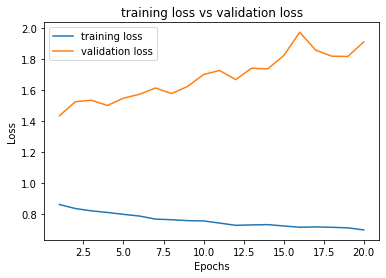

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show the loss
plt.plot(list(range(1, 21)), train_loss, label = "training loss")
plt.plot(list(range(1, 21)), validation_loss, label = "validation loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.title("{} vs {}".format("training loss", "validation loss"))
plt.show()

### 1.7 Eval the trained network

In [ ]:
def eval_net(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images = data[0]
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

eval_net(net, testloader)

### Part 2: Hyperparameters Selection
Following the instruction file, you need to make choices for each hyperparameters:

1. Batch size:
2. Base learning rate:
3. Number of epochs: 

**Question**: Why do you make such choices? Use some figures, math equations, codes and printout to make analysis.

In [ ]:
# Your codes here. 
# Please do not define the networks again, just make changes to the training procedure, i.e. in the loop, please go through all the potential choices.


##### your analysis comes here:
-----
1) 

2) 



### Part 3: More options

Please indicate the **three** tasks you are assigned here:

1) Transformation: e.g. Resize (hyperparameters: size, interpolation), ...

2) Structure: 

3) Training procedure: 

For your new baseline and the test for different options, you need to write them in **ONE** single `.py` file. You can debug here, but do **NOT** include your codes in the submitted ipynb file. Your codes for this part will be put in the **project1.py** file.

**Question**: how do you define your new baseline and why? Please highlight the differences between your new baseline and the previous baseline.

##### your analysis comes here:
-----
1) 

2) 


_____

**Question**: how did you test the three tasks and what did you learn? Please use some figures, math equations and output from your codes to make analysis. 

##### your analysis comes here:
-----
1) 

2) 


_____

### Reference
1. Author, Title, url
2. 
3. 

### Specs:
e.g. Your cpu version or GPU version, the memory size of your computer. Your pytorch software versions.